In [1]:
!git clone https://github.com/KAIST-Visual-AI-Group/GrounDiT

Cloning into 'GrounDiT'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 55 (delta 13), reused 23 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 3.53 MiB | 36.53 MiB/s, done.
Resolving deltas: 100% (13/13), done.


### Demo notebook for GrounDiT

In [1]:
!ls

GrounDiT      pixartimagesfix.zip  pixartpsg	shuffeled_dataset.json
pixartimages  pixartimages.zip	   sample_data


In [2]:
%cd GrounDiT

/content/GrounDiT


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
!pip install -r requirements.txt

In [5]:
import os
import json
from functools import partial
from tqdm import tqdm
import torch
from diffusers.utils.torch_utils import randn_tensor

from groundit.pipeline_groundit import ASPECT_RATIO_512_BIN
from groundit.utils import *

device = torch.device("cuda:0")

### Load GrounDiT model (based on PixArt-$\alpha$)

In [6]:
# Set model configs
hw_bin = ASPECT_RATIO_512_BIN
model_id = "PixArt-alpha/PixArt-XL-2-512x512"

# Load GrounDiT model
pipe, tokenizer = load_groundit_model(model_id, device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at PixArt-alpha/PixArt-XL-2-512x512 were not used when initializing Transformer2DModel: 
 ['caption_projection.y_embedding']


### Set text prompt and bounding box conditions

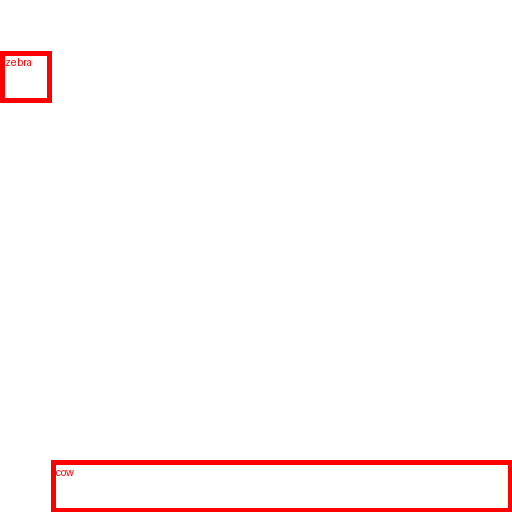

In [17]:
# Text and bounding box conditions for GrounDiT
# NOTE: Change the prompt and phrases to generate different images!
data = {
    "prompt": "a cow to the left of a zebra",
    "phrases": ["cow", "zebra"],
    "bboxes": [[[0.1, 0.9, 1, 1]], [[0.0, 0.1, 0.1, 0.2]]], #Left
    # "bboxes": [[[0.7, 0.9, 1, 1]], [[0.0, 0.1, 0.1, 0.2]]], #Right
    "height": 512,
    "width": 512
}

# Set seed
seed = 2981

# Visualize bounding boxes
bbox_image = Image.new("RGB", (data["width"], data["height"]), (255, 255, 255))
draw_box(
    bbox_image, data["bboxes"], ";".join(data["phrases"]),
    height=data["height"], width=data["width"]
)
bbox_image

### Generate image with GrounDiT!

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1322, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1322, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1294, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1279, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1267, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1244, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1215, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1179, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1152, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
test code change2
tensor(0.1127, device='cuda:0', dtype=torch.float1

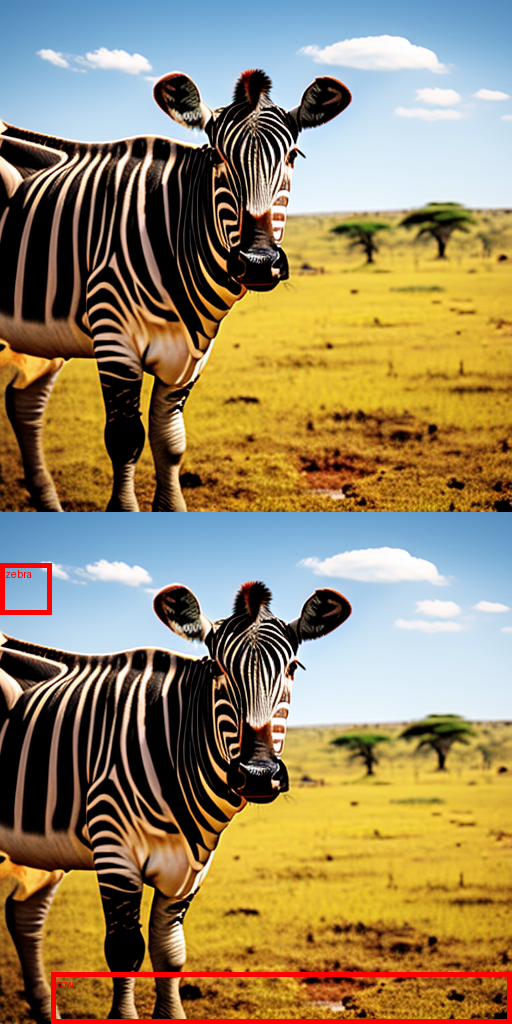

In [20]:
prompt = data["prompt"]
phrases = data["phrases"]
bboxes = data["bboxes"]

bbox_list = sanity_check(bboxes, phrases)

# Find the location of phrase indices in the prompt after tokenization, do it for all pharse in phrases list.
phrases_idx = get_phrases_idx_in_prompt(prompt, phrases, tokenizer)

# Convert bbox coordinates to pixel & latent & patch space. Get the indices of the patches in the patch space that are covered by the bounding box.
# Here boundnig box region corresponds to "Local Patch" in the paper. See Figure 2.
if 'height' in data and 'width' in data:
    original_height, original_width = data['height'], data['width']
    target_height, target_width = pipe.classify_height_width_bin(original_height, original_width, hw_bin)
elif 'aspect_ratio' in data:
    target_height, target_width = pipe.classify_aspect_ratio_bin(data['aspect_ratio'], hw_bin)
    original_height, original_width = target_height, target_width
else:
    raise ValueError("Invalid data format. Need to provide either height/width or aspect_ratio.")

# Set bbox coordinates in pixel space and latent space
latent_height, latent_width = target_height // pipe.vae_scale_factor, target_width // pipe.vae_scale_factor
all_bbox_coord_in_pixel_space = get_bbox_coord_in_pixel_space(bbox_list, target_height, target_width)
all_bbox_coord_in_latent_space = get_bbox_coord_in_latent_space(bbox_list, latent_height, latent_width)

# Get the "Object Image" height and width in pixel space, where "Object Image" is introduced in the paper. See Figure 2.
object_image_hw_in_pixel_space = get_bbox_region_hw(all_bbox_coord_in_pixel_space, hw_bin_classify_func=partial(pipe.classify_height_width_bin, ratios=hw_bin))

# Set seed
seed_everything(seed)
generator = torch.Generator(device=device).manual_seed(seed)

# Main image latent
latent_shape = (1, 4, latent_height, latent_width)
latent = randn_tensor(latent_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma

# Object images latents
object_image_latents_list = list()
for object_image_hw_list in object_image_hw_in_pixel_space:
    object_image_latents_list_for_each_phrase = list()
    for object_image_hw in object_image_hw_list:
        object_image_latents_shape = (1, 4, object_image_hw[0] // pipe.vae_scale_factor, object_image_hw[1] // pipe.vae_scale_factor)
        object_image_latents = randn_tensor(object_image_latents_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma
        object_image_latents_list_for_each_phrase.append(object_image_latents)

    object_image_latents_list.append(object_image_latents_list_for_each_phrase)

    # Generate sample
    image = pipe(
        prompt=prompt,
        width=original_width,
        height=original_height,
        latents=latent,
        # General Arguments
        bbox_list=bbox_list,
        phrases=phrases,
        phrases_idx=phrases_idx,
        # Local Update Config
        loss_scale =30,
          loss_threshold = 0.00001,
          gradient_weight = 5.0,
          global_update_max_iter_per_step = 1,
        object_image_latents_list=object_image_latents_list,
        object_image_hw_in_pixel_space=object_image_hw_in_pixel_space,
        all_bbox_coord_in_latent_space=all_bbox_coord_in_latent_space
    )[0][0]

    return image

# Run images

In [9]:
import random
def rel_box_encode(relation):
  if relation == 'to the right of':
     a = 0.1
  elif relation == 'to the left of':
     a = 0.3
  elif relation == 'above':
     a = 0.5
  elif relation == 'below':
     a = 0.7
  else:
    print("ERROR: undefined relation")
    a = None
  return a

def generate_image(text,objs,rel, do_loss, seed):

    box_a = rel_box_encode(rel)
    box = [[[box_a, 0.9, 1, 1]], [[0.0, 0.1, 0.1, 0.2]]]
    data = {
        "prompt": text,
        "phrases": [objs[0],objs[1]],
        "bboxes": box,
        "height": 512,
        "width": 512
    }
    prompt = data["prompt"]
    phrases = data["phrases"]
    bboxes = data["bboxes"]

    bbox_list = sanity_check(bboxes, phrases)

    phrases_idx = get_phrases_idx_in_prompt(prompt, phrases, tokenizer)

    # Convert bbox coordinates to pixel & latent & patch space. Get the indices of the patches in the patch space that are covered by the bounding box.
    # Here boundnig box region corresponds to "Local Patch" in the paper. See Figure 2.
    if 'height' in data and 'width' in data:
        original_height, original_width = data['height'], data['width']
        target_height, target_width = pipe.classify_height_width_bin(original_height, original_width, hw_bin)
    elif 'aspect_ratio' in data:
        target_height, target_width = pipe.classify_aspect_ratio_bin(data['aspect_ratio'], hw_bin)
        original_height, original_width = target_height, target_width
    else:
        raise ValueError("Invalid data format. Need to provide either height/width or aspect_ratio.")

    # Set bbox coordinates in pixel space and latent space
    latent_height, latent_width = target_height // pipe.vae_scale_factor, target_width // pipe.vae_scale_factor
    all_bbox_coord_in_pixel_space = get_bbox_coord_in_pixel_space(bbox_list, target_height, target_width)
    all_bbox_coord_in_latent_space = get_bbox_coord_in_latent_space(bbox_list, latent_height, latent_width)

    # Get the "Object Image" height and width in pixel space, where "Object Image" is introduced in the paper. See Figure 2.
    object_image_hw_in_pixel_space = get_bbox_region_hw(all_bbox_coord_in_pixel_space, hw_bin_classify_func=partial(pipe.classify_height_width_bin, ratios=hw_bin))

    # Set seed
    seed_everything(seed)
    generator = torch.Generator(device=device).manual_seed(seed)

    # Main image latent
    latent_shape = (1, 4, latent_height, latent_width)
    latent = randn_tensor(latent_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma

    # Object images latents
    object_image_latents_list = list()
    for object_image_hw_list in object_image_hw_in_pixel_space:
        object_image_latents_list_for_each_phrase = list()
        for object_image_hw in object_image_hw_list:
            object_image_latents_shape = (1, 4, object_image_hw[0] // pipe.vae_scale_factor, object_image_hw[1] // pipe.vae_scale_factor)
            object_image_latents = randn_tensor(object_image_latents_shape, generator=generator, device=device, dtype=torch.float16) * pipe.scheduler.init_noise_sigma
            object_image_latents_list_for_each_phrase.append(object_image_latents)

        object_image_latents_list.append(object_image_latents_list_for_each_phrase)

    # Generate sample
    loss_mult = 20
    if not do_loss:
      loss_mult = 0
    image = pipe(
        prompt=prompt,
        width=original_width,
        height=original_height,
        latents=latent,
        # General Arguments
        bbox_list=bbox_list,
        phrases=phrases,
        phrases_idx=phrases_idx,
        # Local Update Config
        loss_scale =loss_mult,
          loss_threshold = 0.00001,
          gradient_weight = 5.0,
          global_update_max_iter_per_step = 1,
        object_image_latents_list=object_image_latents_list,
        object_image_hw_in_pixel_space=object_image_hw_in_pixel_space,
        all_bbox_coord_in_latent_space=all_bbox_coord_in_latent_space
    )[0][0]

    return image


In [10]:
import json
f = open('../shuffeled_dataset.json')
js = json.load(f)
import os
pix_dir = '../pixartss'
os.makedirs(pix_dir, exist_ok=True)
psg_dir = '../psgss'
os.makedirs(psg_dir, exist_ok=True)
for i in range(100):
    entry = js[i]
    uid = entry['unique_id']
    text= entry['text']
    obj1 = entry['obj_1_attributes']
    obj2 = entry['obj_2_attributes']
    relation = entry['rel_type']
    seed = random.randint(0, 1000000)
    img = generate_image(text,[obj1,obj2],relation,True,seed)
    img.save(f'{psg_dir}/{i}.png')
    img = generate_image(text,[obj1,obj2],relation,False,seed)
    img.save(f'{pix_dir}/{i}.png')

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1320, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1292, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1294, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1262, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1229, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1205, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1187, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1171, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1152, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1132, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1110, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1320, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1299, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1282, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1296, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1272, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1232, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1320, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1332, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1334, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1334, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1260, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1244, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1226, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1193, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1180, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1157, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1135, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1118, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1110, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1048, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0941, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0953, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0961, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1260, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1243, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1228, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1201, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1183, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1164, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1154, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1141, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1143, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1133, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1119, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1097, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1058, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1244, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1248, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1260, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1274, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1287, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1299, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1296, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1292, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1287, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1284, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1228, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1193, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1244, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1249, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1255, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1272, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1296, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1299, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1339, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1279, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1332, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1475, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1490, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1484, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1506, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1504, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1531, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1541, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1536, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1541, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1555, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1582, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1591, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1602, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1475, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1484, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1487, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1504, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1533, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1527, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1547, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1549, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1555, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1602, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1649, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1656, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1694, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1294, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1282, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1272, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1260, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1250, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1238, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1235, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1233, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1230, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1211, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1205, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1186, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1296, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1284, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1279, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1267, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1257, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1250, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1252, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1255, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1249, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1257, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1227, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1223, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.0945, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0927, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0909, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0901, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0869, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0863, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0860, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0824, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0822, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0822, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0819, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0819, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0814, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.0945, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0927, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0912, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0903, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0884, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0865, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0865, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0837, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0829, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0830, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0830, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0829, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0829, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1157, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1155, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1151, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1152, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1151, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1149, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1152, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1154, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1161, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1160, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1164, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1136, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1135, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1157, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1154, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1152, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1154, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1153, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1155, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1154, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1165, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1183, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1180, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1194, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1172, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1165, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1324, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1329, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1329, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1327, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1329, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1320, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1322, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1312, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1296, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1292, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1284, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1270, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1324, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1320, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1324, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1329, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1324, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1317, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1332, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1322, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1324, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1320, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1315, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1299, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1299, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1294, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1294, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1301, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1304, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1310, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1312, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1344, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1342, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1344, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1342, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1344, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1346, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1339, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1346, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1334, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1307, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1284, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1252, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1221, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1344, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1344, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1344, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1346, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1353, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1362, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1370, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1372, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1381, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1370, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1372, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1365, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1367, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1312, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1274, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1246, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1203, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1160, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1109, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1047, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1000, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0963, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0925, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0897, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0878, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.0859, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1312, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1277, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1262, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1215, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1199, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1183, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1132, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1101, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1088, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1074, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1069, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1058, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)
tensor(0.1046, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)

KeyboardInterrupt: 

In [18]:
import gc
import torch

# del model  # your CLIP model variable
torch.cuda.empty_cache()
gc.collect()

272

In [17]:
!ls pixartimages

0.png	 120.png  141.png  162.png  183.png  23.png  44.png  65.png  86.png
100.png  121.png  142.png  163.png  184.png  24.png  45.png  66.png  87.png
101.png  122.png  143.png  164.png  185.png  25.png  46.png  67.png  88.png
102.png  123.png  144.png  165.png  186.png  26.png  47.png  68.png  89.png
103.png  124.png  145.png  166.png  187.png  27.png  48.png  69.png  8.png
104.png  125.png  146.png  167.png  188.png  28.png  49.png  6.png   90.png
105.png  126.png  147.png  168.png  189.png  29.png  4.png   70.png  91.png
106.png  127.png  148.png  169.png  18.png   2.png   50.png  71.png  92.png
107.png  128.png  149.png  16.png   190.png  30.png  51.png  72.png  93.png
108.png  129.png  14.png   170.png  191.png  31.png  52.png  73.png  94.png
109.png  12.png   150.png  171.png  192.png  32.png  53.png  74.png  95.png
10.png	 130.png  151.png  172.png  193.png  33.png  54.png  75.png  96.png
110.png  131.png  152.png  173.png  194.png  34.png  55.png  76.png  97.png
111.png  132.png